# Active Learning Experiments

## Strategy Comparison

In [158]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

# Cifar-10
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar10')
# experiment_id = '129408172103829518'

# STL 10
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/stl10')
# experiment_id = '985806158213680859'

# Cifar-100
client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar100')
experiment_id = '596005995110882332'

# Food-101
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/food101')
# experiment_id = '270441571896962032'

runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 973 experiments


In [169]:
runs = []
init_query_list = [
    "parameter.al.num_acq = '20'",
    "parameter.al.acq_size = '100'",
    "parameter.al.num_init_samples = '100'",
    "parameter.model.name = 'laplace'",
    "parameter.dino_model_name = 'dinov2_vits14'",
    "parameter.al.init_method = 'random'",
    # "parameter.update_gamma = '10'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

# query_list = init_query_list + ["parameter.al.strategy = 'margin'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

# query_list = init_query_list + ["parameter.al.strategy = 'badge'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'typiclust'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.fisher_approximation = 'full'"] 
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'pseudo_bait'"]
query_list += ["parameter.al.fisher_approximation = 'full'"] 
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query_list[0] = "parameter.al.num_acq = '200'"
# query_list[1] = "parameter.al.acq_size = '1'"
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'single_' +  r.data.params['al.strategy']
# runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_margin'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

# query_list = init_query_list + ["parameter.al.strategy = 'batch_bald'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_bald'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

# query_list = init_query_list 
# query_list += ["parameter.al.strategy = 'pseudo_badge'"] 
# query_list += ["parameter.al.update_every = '1'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

print('Found {} experiments'.format(len(runs)))

Found 179 experiments


In [170]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    # if "al.update_every" in run.data.params: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))


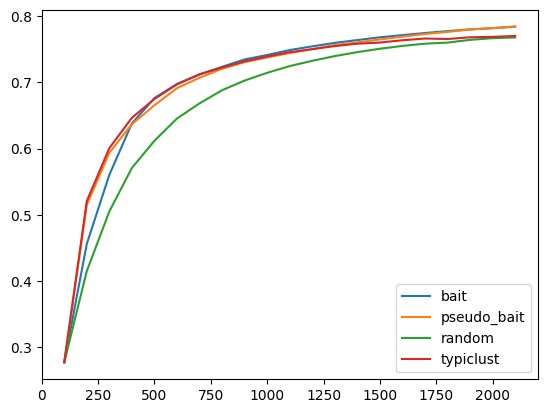

In [171]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

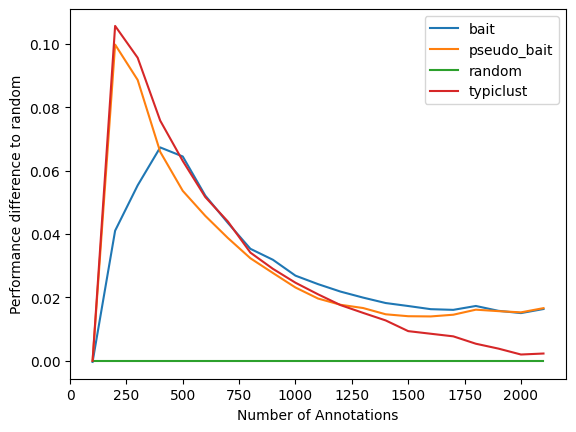

In [165]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)

for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lc = np.mean(lcs, axis=0)
    plt.plot(axis, lc - lc_random, label=al_strat)

plt.xlabel('Number of Annotations')
plt.ylabel('Performance difference to random')
plt.legend()

0


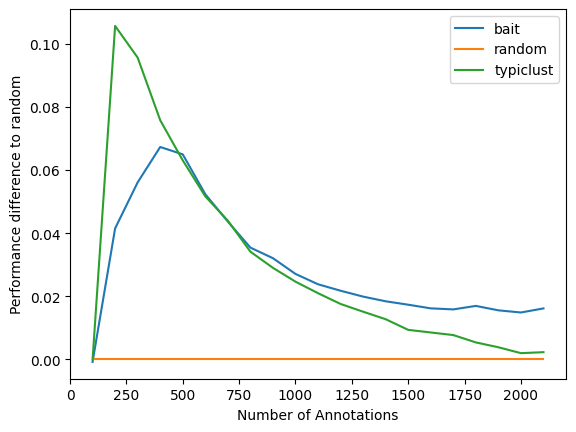

In [83]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)

for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lc = np.mean(lcs, axis=0)
    plt.plot(axis, lc - lc_random, label=al_strat)

plt.xlabel('Number of Annotations')
plt.ylabel('Performance difference to random')
plt.legend()
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar10_ablation')
# experiment_id = '781884387011814498'
client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar100_ablation')
experiment_id = '864948186637600949'
init_query_list = [
    "parameter.al.num_acq = '20'",
    "parameter.al.acq_size = '100'",
    "parameter.al.num_init_samples = '100'",
    "parameter.update_gamma = '10'",
    "parameter.al.init_method= 'diverse_dense'",
]
query_list = init_query_list + ["parameter.al.strategy = 'bait'"] + ["parameter.al.fisher_approximation = 'max_pred'"]
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)

query_list = init_query_list + ["parameter.al.strategy = 'badge'"]
query = ' and '.join(query_list)
runs_.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

print(len(runs_))

al_strats = np.unique([run.data.params['al.strategy'] for run in runs_])

learning_curves = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs_:
    al_strat = run.data.params['al.strategy']
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))


In [78]:
lc_bait_approx = np.mean(learning_curves['bait'], 0)
lc_badge_approx = np.mean(learning_curves['badge'], 0)

# plt.plot(axis, lc_bait - lc_random, label='Bait')
plt.plot(axis, lc_bait_approx - lc_random, label='Bait Approx')
plt.plot(axis, lc_badge - lc_random, label='Badge')
plt.plot(axis, lc_badge_approx - lc_random, label='Badge Approx')
plt.plot(axis, lc_typiclust - lc_random, label='Typiclust')

# plt.plot(axis, lc_margin- lc_random, label='Margin')
# plt.plot(axis, lc_pseudo_margin - lc_random, label='PseudoMargin')
# plt.plot(axis, lc_pseudo_bald - lc_random, label='PseudoBALD')
plt.xlabel('Number of Annotations')
plt.ylabel('Performance difference to random')
plt.legend()

KeyError: 'bait'

In [166]:
client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar100_ablation')
experiment_id = '864948186637600949'
init_query_list = [
    "parameter.al.num_acq = '2000'",
    "parameter.al.acq_size = '1'",
    "parameter.al.num_init_samples = '100'",
    "parameter.model.name = 'laplace'",
    "parameter.dino_model_name = 'dinov2_vits14'",
    "parameter.update_gamma = '10'",
    "parameter.al.init_method= 'diverse_dense'",
]
query_list = init_query_list + ["parameter.al.strategy = 'badge'"]
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
print('Found {} experiments'.format(len(runs_)))
for r in runs_:
    r.data.params['al.strategy'] = 'single_' +  r.data.params['al.strategy']

al_strats = np.unique([run.data.params['al.strategy'] for run in runs_])

learning_curves = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs_:
    al_strat = run.data.params['al.strategy']
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))


Found 50 experiments


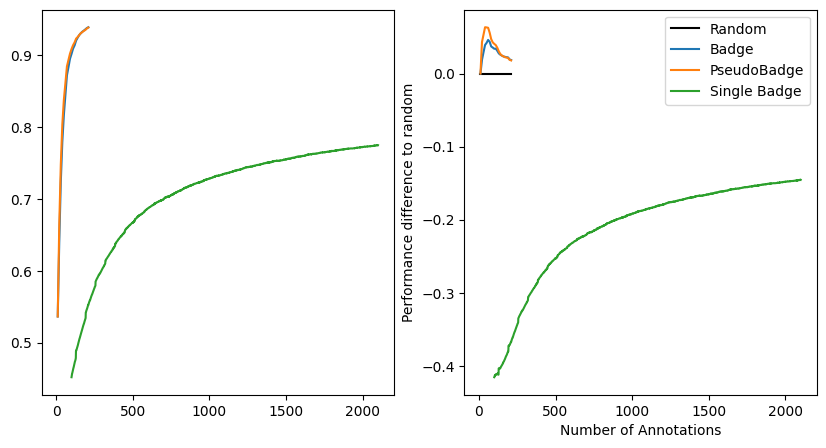

In [167]:
plt.figure(figsize=(10, 5))
axis_ = np.mean(num_samples['single_badge'], 0)
lc_single_badge = np.mean(learning_curves['single_badge'], 0)
lc_single_random = np.interp(axis_, axis ,lc_random)

plt.subplot(121)
plt.plot(axis, lc_badge, label='Badge')
plt.plot(axis, lc_pseudo_badge, label='PseudoBadge')
plt.plot(axis_, lc_single_badge, label='SingleBadge')

plt.subplot(122)
plt.plot(axis, np.zeros_like(axis), 'k', label='Random')
plt.plot(axis, lc_badge - lc_random, label='Badge')
plt.plot(axis, lc_pseudo_badge - lc_random, label='PseudoBadge')
plt.plot(axis_, lc_single_badge - lc_single_random, label='Single Badge')

plt.xlabel('Number of Annotations')
plt.ylabel('Performance difference to random')
plt.legend()

## Comparing to single-instance Acquisition

In [2]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

# Cifar-10
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar10')

# STL 10
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/stl10')
# experiment_id = '325147658587907143'

# Cifar-100
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar100_ablation')
# experiment_id = '864948186637600949'

# Food-101
client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/food101')
experiment_id = '270441571896962032'

runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 400 experiments


In [5]:
runs = []
init_query_list = [
    "parameter.al.num_acq = '20'",
    "parameter.al.acq_size = '100'",
    "parameter.al.num_init_samples = '100'",
    "parameter.model.name = 'laplace'",
    "parameter.dino_model_name = 'dinov2_vits14'",
    "parameter.update_gamma = '10'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

# Margin
# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_margin'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'margin'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'margin'"]
# query_list[0] = "parameter.al.num_acq = '200'"
# query_list[1] = "parameter.al.acq_size = '1'"
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'single_' + r.data.params['al.strategy']
# runs.extend(runs_)

# BALD
# query_list = init_query_list + ["parameter.al.strategy = 'bald'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_bald'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'bald'"]
# query_list[-3] = "parameter.al.num_acq = '100'"
# query_list[-4] = "parameter.al.acq_size = '1'"
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'single_' + r.data.params['al.strategy']
# runs.extend(runs_)

# Badge
query_list = init_query_list + ["parameter.al.strategy = 'pseudo_badge'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
query_list = init_query_list + ["parameter.al.strategy = 'badge'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
query_list = init_query_list + ["parameter.al.strategy = 'badge'"]
query_list[0] = "parameter.al.num_acq = '2000'"
query_list[1] = "parameter.al.acq_size = '1'"
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'single_' +  r.data.params['al.strategy']
runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_bait'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query_list[-3] = "parameter.al.num_acq = '100'"
# query_list[-4] = "parameter.al.acq_size = '1'"
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'single_' +  r.data.params['al.strategy']
# runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 200 experiments


In [6]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))


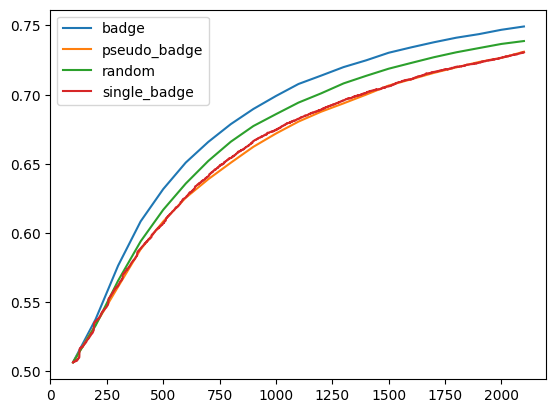

In [7]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

## Check influence of mean field factor

In [54]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

# Cifar-10
client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar10_mean_field')
experiment_id = '924061412889829321'

# STL 10
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/stl10')
# experiment_id = '325147658587907143'

# Cifar-100
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/cifar100')
# experiment_id = '754775338603262051'

# Food-101
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/food101')
# experiment_id = ''

runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 1000 experiments


In [55]:
runs = []
init_query_list = [
    "parameter.model.mean_field_factor = '0.0001'",
    "parameter.model.name = 'laplace'",
    "parameter.dino_model_name = 'dinov2_vits14'",
    "parameter.al.num_init_samples = '10'",
    "parameter.al.num_acq = '10'",
    "parameter.al.acq_size = '10'",
    "parameter.update_gamma = '10'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

# Entropy
# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_entropy'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'entropy'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'entropy'"]
# query_list[-3] = "parameter.al.num_acq = '100'"
# query_list[-4] = "parameter.al.acq_size = '1'"
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'single_' + r.data.params['al.strategy']
# runs.extend(runs_)

# BALD
# query_list = init_query_list + ["parameter.al.strategy = 'bald'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_bald'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'bald'"]
# query_list[-3] = "parameter.al.num_acq = '100'"
# query_list[-4] = "parameter.al.acq_size = '1'"
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'single_' + r.data.params['al.strategy']
# runs.extend(runs_)

# Badge
query_list = init_query_list + ["parameter.al.strategy = 'badge'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
query_list = init_query_list + ["parameter.al.strategy = 'badge'"]
query_list[-3] = "parameter.al.num_acq = '100'"
query_list[-4] = "parameter.al.acq_size = '1'"
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'single_' +  r.data.params['al.strategy']
runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_bait'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))
# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query_list[-3] = "parameter.al.num_acq = '100'"
# query_list[-4] = "parameter.al.acq_size = '1'"
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'single_' +  r.data.params['al.strategy']
# runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 200 experiments


In [56]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    if len(run.data.metrics) == 0: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    if len(acc_history) < 11: continue
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))


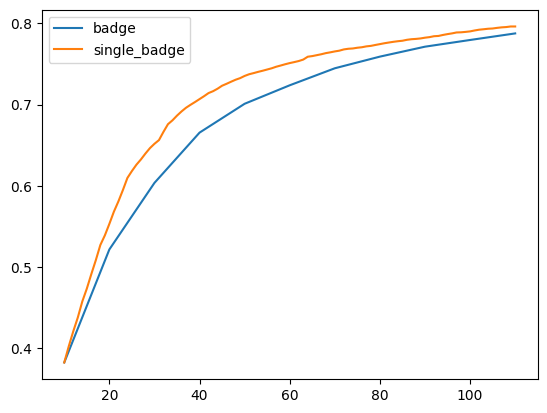

In [53]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

# Bait Approximation

## Approximation Expectation

In [21]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

# Cifar-10
client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/cifar10_bait_ablation.db')
# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/stl10_bait_ablation.db')
# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/cifar100_bait_ablation.db')
# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/svhn_bait_ablation.db')
experiment_id = client.get_experiment_by_name('Active Learning').experiment_id

# Food-101
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/food101')
# experiment_id = '270441571896962032'
runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 200 experiments


In [25]:
runs = []
init_query_list = [
    "parameter.model.name = 'laplace'",
    "parameter.dino_model_name = 'dinov2_vits14'",
    "parameter.update_gamma = '10'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

# query_list = init_query_list + ["parameter.al.strategy = 'typiclust'"]
# query = ' and '.join(query_list)
# runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'full_' + r.data.params['al.strategy']
runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = '5'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'{r.data.params["al.bait.expectation_topk"]}' + r.data.params['al.strategy']
runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = '2'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'{r.data.params["al.bait.expectation_topk"]}' + r.data.params['al.strategy']
runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = '1'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'{r.data.params["al.bait.expectation_topk"]}' + r.data.params['al.strategy']
runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 100 experiments


In [26]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    # if "al.update_every" in run.data.params: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))


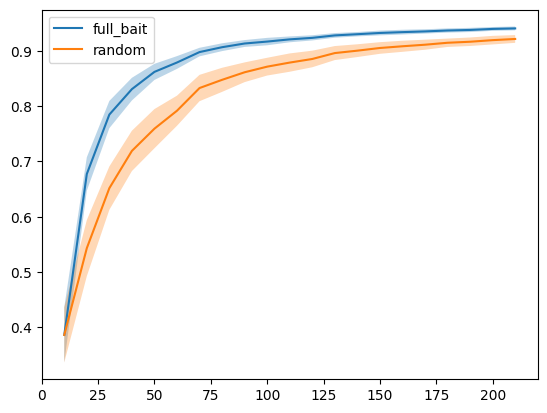

In [27]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20]
    # print([len(lc) for lc in lcs if len(lc)< ])

    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

## Grad Sampling

In [ ]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

# Cifar-10
client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/cifar10_bait_ablation.db')
# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/stl10_bait_ablation.db')
# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/cifar100_bait_ablation.db')
# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/svhn_bait_ablation.db')
experiment_id = client.get_experiment_by_name('Active Learning').experiment_id

# Food-101
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/food101')
# experiment_id = '270441571896962032'
runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 500 experiments


In [16]:
runs = []
init_query_list = [
    "parameter.model.name = 'laplace'",
    "parameter.dino_model_name = 'dinov2_vits14'",
    "parameter.update_gamma = '10'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'typiclust'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'full_' + r.data.params['al.strategy']
runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.num_grad_samples = '384'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'grad{r.data.params["al.bait.num_grad_samples"]}_' + r.data.params['al.strategy']
runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.num_grad_samples = '768'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'grad{r.data.params["al.bait.num_grad_samples"]}_' + r.data.params['al.strategy']
runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.num_grad_samples = '1152'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'grad{r.data.params["al.bait.num_grad_samples"]}_' + r.data.params['al.strategy']
runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.num_grad_samples = '1536'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'grad{r.data.params["al.bait.num_grad_samples"]}_' + r.data.params['al.strategy']
runs.extend(runs_)


# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query_list += ["parameter.al.bait.fisher_approximation = 'max_pred'"] 
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'max_pred_' + r.data.params['al.strategy']
# runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_bait'"]
# query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'full_' + r.data.params['al.strategy']
# runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_bait'"]
# query_list += ["parameter.al.bait.fisher_approximation = 'topk'"] 
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'topk_' + r.data.params['al.strategy']
# runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'pseudo_bait'"]
# query_list += ["parameter.al.bait.fisher_approximation = 'max_pred'"] 
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = 'max_pred_' + r.data.params['al.strategy']
# runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 450 experiments


In [17]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    # if "al.update_every" in run.data.params: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))


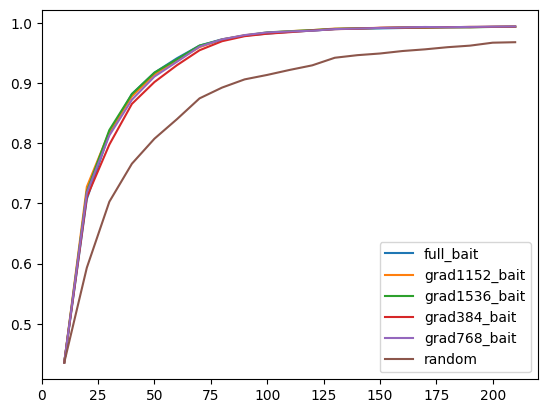

In [18]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20]
    # print([len(lc) for lc in lcs if len(lc)< ])

    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

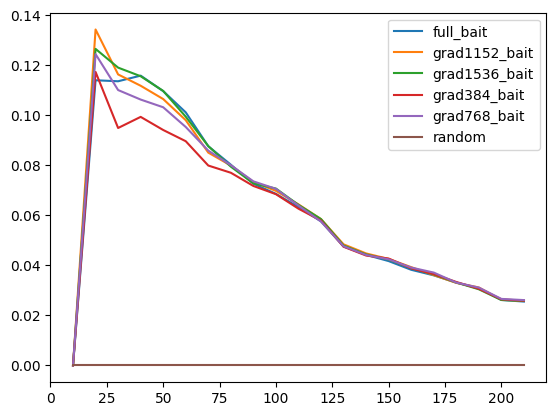

In [19]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)

for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20 ]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)

    plt.plot(axis, lc - lc_random, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

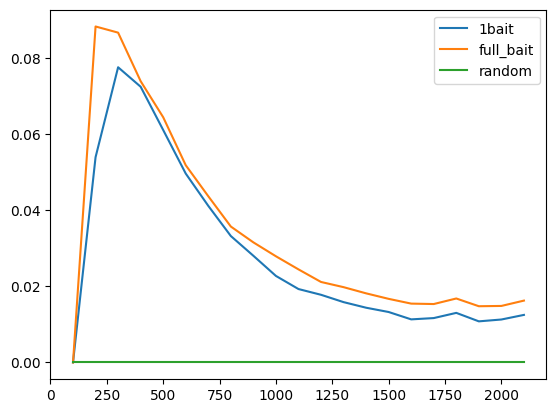

In [11]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)

for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20 ]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)

    plt.plot(axis, lc - lc_random, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

## Intelligent Sampling

In [1]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

# Cifar-10
client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/cifar10_bait_ablation.db')
# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/stl10_bait_ablation.db')
# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/cifar100_bait_ablation.db')
# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/svhn_bait_ablation.db')
experiment_id = client.get_experiment_by_name('Active Learning').experiment_id

# Food-101
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/food101')
# experiment_id = '270441571896962032'
runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 200 experiments


In [2]:

runs = []
init_query_list = [
    "parameter.model.name = 'laplace'",
    "parameter.dino_model_name = 'dinov2_vits14'",
    "parameter.update_gamma = '10'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'full_' + r.data.params['al.strategy']
runs.extend(runs_)


query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.num_grad_samples = '500'"] 
query_list += ["parameter.al.bait.grad_selection = 'random'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = r.data.params['al.bait.grad_selection'] + '_' + r.data.params['al.strategy']
runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.num_grad_samples = '500'"] 
query_list += ["parameter.al.bait.grad_selection = 'magnitude'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = r.data.params['al.bait.grad_selection'] + '_' + r.data.params['al.strategy']
runs.extend(runs_)


query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.num_grad_samples = '500'"] 
query_list += ["parameter.al.bait.grad_selection = 'std'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = r.data.params['al.bait.grad_selection'] + '_' + r.data.params['al.strategy']
runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 150 experiments


In [3]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    # if "al.update_every" in run.data.params: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))


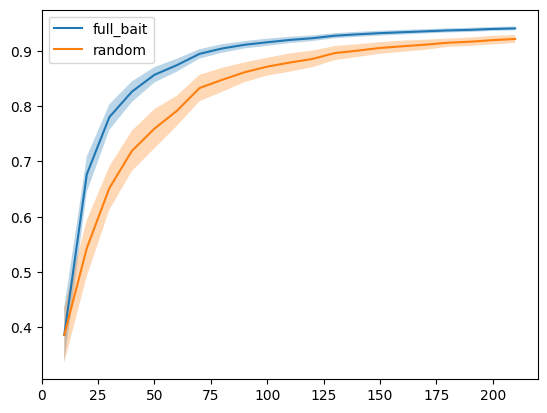

In [4]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20]
    # print([len(lc) for lc in lcs if len(lc)< ])

    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

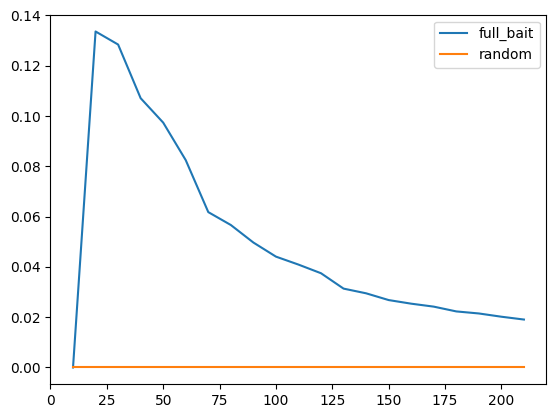

In [5]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)

for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20 ]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)

    plt.plot(axis, lc - lc_random, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

## Gradient Likelihood

In [1]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/cifar10_bait_ablation.db')
# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/stl10_bait_ablation.db')
# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/cifar100_bait_ablation.db')
# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/ssal/al/food101_bait_ablation.db')
experiment_id = client.get_experiment_by_name('Active Learning').experiment_id

# Food-101
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/food101')
# experiment_id = '270441571896962032'
runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 200 experiments


In [2]:
runs = []
init_query_list = [
    "parameter.model.name = 'laplace'",
    "parameter.dino_model_name = 'dinov2_vits14'",
    "parameter.update_gamma = '10'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'typiclust'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'badge'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'original_' + r.data.params['al.strategy']
runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
# query_list += ["parameter.al.bait.grad_likelihood = 'binary_cross_entropy'"] 
# query_list += ["parameter.al.bait.expectation_topk = '1'"] 
# query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] += '_' + r.data.params['al.bait.grad_likelihood'] 
#     r.data.params['al.strategy'] += '_' + r.data.params['al.bait.expectation_topk']
# runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'binary_cross_entropy'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.grad_selection = 'magnitude'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] += '_' + r.data.params['al.bait.grad_likelihood'] 
    r.data.params['al.strategy'] += '_' + r.data.params['al.bait.expectation_topk']
runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
# query_list += ["parameter.al.bait.grad_likelihood = 'binary_cross_entropy'"] 
# query_list += ["parameter.al.bait.expectation_topk = '1'"] 
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] += '_' + r.data.params['al.bait.grad_likelihood'] 
#     r.data.params['al.strategy'] += '_' + r.data.params['al.bait.expectation_topk']
# runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
# query_list += ["parameter.al.bait.grad_likelihood = 'binary_cross_entropy'"] 
# query_list += ["parameter.al.bait.expectation_topk = '2'"] 
# query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] += '_' + r.data.params['al.bait.grad_likelihood'] 
#     r.data.params['al.strategy'] += '_' + r.data.params['al.bait.expectation_topk'] 
# runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
# query_list += ["parameter.al.bait.grad_likelihood = 'binary_cross_entropy'"] 
# query_list += ["parameter.al.bait.expectation_topk = '5'"] 
# query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] += '_' + r.data.params['al.bait.grad_likelihood'] 
#     r.data.params['al.strategy'] += '_' + r.data.params['al.bait.expectation_topk'] 
# runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
# query_list += ["parameter.al.bait.grad_likelihood = 'binary_cross_entropy'"] 
# query_list += ["parameter.al.bait.expectation_topk = '8'"] 
# query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] += '_' + r.data.params['al.bait.grad_likelihood'] 
#     r.data.params['al.strategy'] += '_' + r.data.params['al.bait.expectation_topk'] 
# runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
# query_list += ["parameter.al.bait.grad_likelihood = 'binary_cross_entropy'"] 
# query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
# query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] += '_' + r.data.params['al.bait.grad_likelihood'] 
#     r.data.params['al.strategy'] += '_' + r.data.params['al.bait.expectation_topk'] 
# runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 200 experiments


In [3]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    # if "al.update_every" in run.data.params: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))


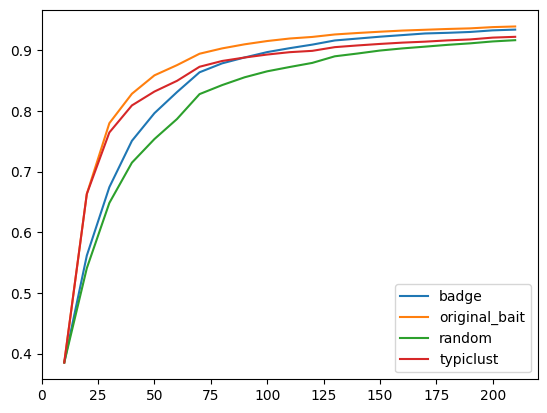

In [4]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20]
    # print([len(lc) for lc in lcs if len(lc)< ])

    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

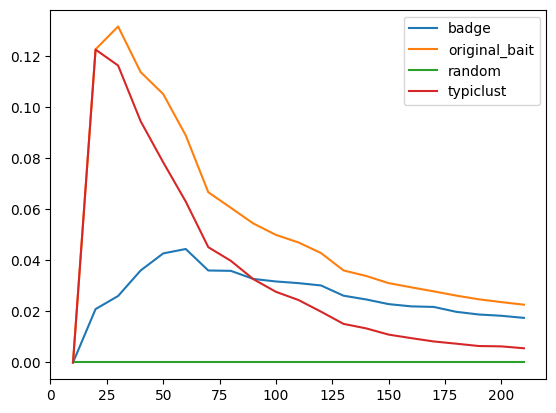

In [5]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
lcs_random = learning_curves['random']

for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20 ]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)

    plt.plot(axis, lc - lc_random, label=al_strat)

plt.legend()
plt.show()

In [6]:
import matplotlib.pyplot as plt

#plt.style.use('seaborn-v0_8-pastel')
plt.style.use('bmh')
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
# plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.family"] = "serif"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


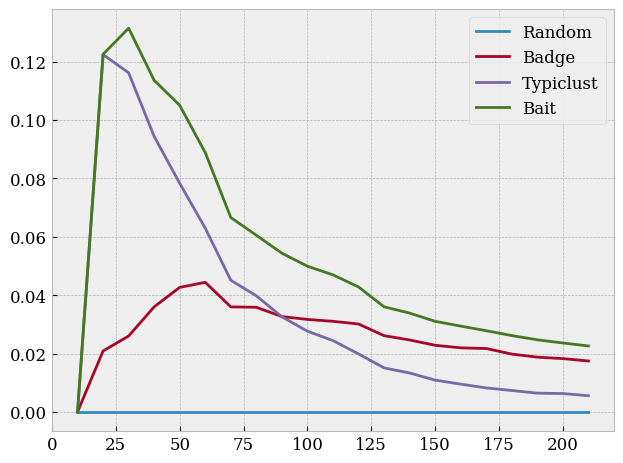

In [44]:
mapping = {
    'random': 'Random', 
    'typiclust':'Typiclust', 
    'badge':'Badge', 
    'original_bait':'Bait', 
    'bait_binary_cross_entropy_None': 'Bait Approximation'
}

axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
    
plt.plot(axis, np.mean(learning_curves['random'], axis=0) - lc_random, label='Random')
plt.plot(axis, np.mean(learning_curves['badge'], axis=0) - lc_random, label='Badge')
plt.plot(axis, np.mean(learning_curves['typiclust'], axis=0) - lc_random, label='Typiclust')
plt.plot(axis, np.mean(learning_curves['original_bait'], axis=0) - lc_random, label='Bait')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig('graphical_abstract_a.pdf')
plt.show()

In [45]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

query_times = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    qtime_history = client.get_metric_history(run.info.run_id, 'query_time')
    query_times[al_strat].append([metric.value for metric in qtime_history][1:])

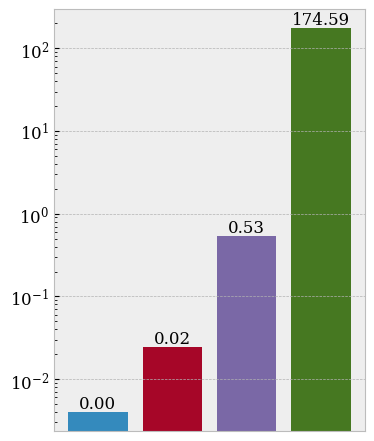

In [46]:
from datetime import timedelta

plt.figure(figsize=(4, 4.8))
for strat in ['random', 'badge', 'typiclust', 'original_bait']:
    bar = plt.bar(strat, np.mean(query_times[strat]))

    for rect in bar:
        x = rect.get_x() + rect.get_width() / 2
        height = rect.get_height()
        plt.text(x, height, f'{height:.2f}', ha='center', va='bottom')


plt.gca().set_yscale('log')
plt.tight_layout()
plt.gca().xaxis.set_visible(False)

# plt.ylabel('Acquisition Time')
plt.savefig('graphical_abstract_b.pdf')
plt.show()